In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import tensorflow.keras.backend as K
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [2]:

# Load the datasets
ask_data = pd.read_csv('AAPLUSUSD_4 Hours_Ask_2021.01.01_2023.12.31.csv')
bid_data = pd.read_csv('AAPLUSUSD_4 Hours_Bid_2021.01.01_2023.12.31.csv')


In [3]:
# Rename 'Ask_Open' and 'Bid_Open' columns to 'Open' in ask_data and bid_data respectively
ask_data.rename(columns={'Ask_Open': 'Open'}, inplace=True)
bid_data.rename(columns={'Bid_Open': 'Open'}, inplace=True)

In [4]:
# Convert 'Time (EET)' column to datetime format and set it as the index for ask_data and bid_data
ask_data['Time (EET)'] = pd.to_datetime(ask_data['Time (EET)'])
bid_data['Time (EET)'] = pd.to_datetime(bid_data['Time (EET)'])
ask_data.set_index('Time (EET)', inplace=True)
bid_data.set_index('Time (EET)', inplace=True)

In [5]:
# Merge the datasets on 'Timestamp'
combined_data = ask_data.merge(bid_data, left_index=True, right_index=True, suffixes=('_ask', '_bid'))

In [6]:
#Feature engineering
# Calculating 10-period rolling volatility for ask and bid closing prices and add as new columns
combined_data['Volatility_ask'] = combined_data['Close_ask'].rolling(window=10).std()
combined_data['Volatility_bid'] = combined_data['Close_bid'].rolling(window=10).std()

# Calculating 10-period Simple Moving Average for ask and bid closing prices and add as new columns
combined_data['SMA_10_ask'] = combined_data['Close_ask'].rolling(window=10).mean()
combined_data['SMA_10_bid'] = combined_data['Close_bid'].rolling(window=10).mean()

#Relative Strength Index
# Calculating the 14-period RSI for ask closing prices and add it as a new column 'RSI_ask'
delta_ask = combined_data['Close_ask'].diff()
gain_ask = (delta_ask.where(delta_ask > 0, 0)).rolling(window=14).mean()
loss_ask = (-delta_ask.where(delta_ask < 0, 0)).rolling(window=14).mean()
rs_ask = gain_ask / loss_ask
combined_data['RSI_ask'] = 100 - (100 / (1 + rs_ask))

# Calculating the 14-period RSI for bid closing prices and add it as a new column 'RSI_bid'
delta_bid = combined_data['Close_bid'].diff()
gain_bid = (delta_bid.where(delta_bid > 0, 0)).rolling(window=14).mean()
loss_bid = (-delta_bid.where(delta_bid < 0, 0)).rolling(window=14).mean()
rs_bid = gain_bid / loss_bid
combined_data['RSI_bid'] = 100 - (100 / (1 + rs_bid))




In [7]:
# Check and clean any NaN values 
combined_data.dropna(inplace=True)

In [8]:
# Save as a diffrent file and read
combined_data.to_csv('combined_AAPLUSUSD1_data.csv')
data = pd.read_csv('combined_AAPLUSUSD_data.csv')


In [9]:
# Shift 'Open_ask' to create 'Next Day Open', calculate if the price gap closes, and drop rows with missing 'Next Day Open'
data['Next Day Open'] = data['Open_ask'].shift(-6)

# Determining if the gap closes using the 'Ask' closing price
data['Gap Close'] = (data['Next Day Open'] > data['Close_ask']).astype(int)

# Drop rows where 'Next Day Open' is NaN which occurs for the last few rows due to the shift operation
data.dropna(subset=['Next Day Open'], inplace=True)
print(data[['Open_ask', 'Close_ask', 'Next Day Open', 'Gap Close']].head())

   Open_ask  Close_ask  Next Day Open  Gap Close
0   127.963    128.833        128.492          0
1   128.812    131.132        127.783          0
2   131.132    130.962        128.052          0
3   130.793    130.142        128.683          0
4   130.133    129.093        131.893          1


In [10]:
# Calculate the Simple Moving Averages for the 'Ask' closing price
data['SMA_4_ask'] = data['Close_ask'].rolling(window=4).mean()
data['SMA_8_ask'] = data['Close_ask'].rolling(window=8).mean()

# Calculate the Simple Moving Averages for the 'Bid' closing price
data['SMA_4_bid'] = data['Close_bid'].rolling(window=4).mean()
data['SMA_8_bid'] = data['Close_bid'].rolling(window=8).mean()

# Calculate the price range for ask and bid prices and store them as 'Ask_Price_Range' and 'Bid_Price_Range'
data['Ask_Price_Range'] = data['High_ask'] - data['Low_ask']
data['Bid_Price_Range'] = data['High_bid'] - data['Low_bid']

# Calculate the difference between ask and bid volumes and store it as 'Volume_Diff'
data['Volume_Diff'] = data['Volume _ask'] - data['Volume _bid']

# Calculate the cumulative sum of ask and bid volumes and store them as 'Cumulative_Volume_Ask' and 'Cumulative_Volume_Bid'
data['Cumulative_Volume_Ask'] = data['Volume _ask'].cumsum()
data['Cumulative_Volume_Bid'] = data['Volume _bid'].cumsum()

# Calculate the percentage change for ask and bid closing prices and store them as 'Pct_Change_Close_Ask' and 'Pct_Change_Close_Bid'
data['Pct_Change_Close_Ask'] = data['Close_ask'].pct_change()
data['Pct_Change_Close_Bid'] = data['Close_bid'].pct_change()

# Calculate the weighted closing price for ask and bid based on volume and store them as 'Weighted_Price_Ask' and 'Weighted_Price_Bid'
data['Weighted_Price_Ask'] = (data['Close_ask'] * data['Volume _ask']) / data['Volume _ask'].sum()
data['Weighted_Price_Bid'] = (data['Close_bid'] * data['Volume _bid']) / data['Volume _bid'].sum()


# Drop rows with NaN values that were created as a result of the rolling mean calculation
data.dropna(inplace=True)
print(data[['Close_ask', 'SMA_4_ask', 'SMA_8_ask', 'Close_bid', 'SMA_4_bid', 'SMA_8_bid']].head())

    Close_ask  SMA_4_ask   SMA_8_ask  Close_bid  SMA_4_bid   SMA_8_bid
7     128.053  128.18525  129.226250    128.027  128.10975  129.175000
8     127.842  127.87250  129.102375    127.808  127.83000  129.051375
9     131.882  128.71975  129.196125    131.858  128.67525  129.143875
10    132.012  129.94725  129.327375    131.988  129.92025  129.276375
11    136.172  131.97700  130.081125    136.158  131.95300  130.031375


In [11]:
# Define features
features = data[['Open_ask', 'High_ask', 'Low_ask', 'Close_ask', 'Volume _ask', 'Volume _bid','Open_bid', 'High_bid', 'Low_bid', 'Close_bid', 
                 'SMA_4_ask', 'SMA_8_ask', 'SMA_4_bid', 'SMA_8_bid', 'Next Day Open']]

# Define the target variable
target = data['Gap Close']

# Print previews to verify everything is set up correctly
print("Features preview:")
print(features.head())
print("\nTarget preview:")
print(target.head())

Features preview:
    Open_ask  High_ask  Low_ask  Close_ask  Volume _ask  Volume _bid  \
7    127.783   128.722  126.942    128.053     562.2900    721.58318   
8    128.052   128.263  127.652    127.842     294.7350    369.92089   
9    128.683   132.263  128.573    131.882     576.3600    729.69208   
10   131.893   132.493  131.752    132.012     275.3550    347.58944   
11   133.962   136.383  133.613    136.172     613.7325    778.83250   

    Open_bid  High_bid  Low_bid  Close_bid  SMA_4_ask   SMA_8_ask  SMA_4_bid  \
7    127.697   128.688  126.927    128.027  128.18525  129.226250  128.10975   
8    128.038   128.248  127.627    127.808  127.87250  129.102375  127.83000   
9    128.647   132.238  128.527    131.858  128.71975  129.196125  128.67525   
10   131.867   132.477  131.727    131.988  129.94725  129.327375  129.92025   
11   133.848   136.368  133.577    136.158  131.97700  130.081125  131.95300   

     SMA_8_bid  Next Day Open  
7   129.175000        136.422  
8   

In [12]:
# Scaling features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [13]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

In [14]:
# Reshape X_train and X_test to be 3D, as expected by LSTM layers
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [15]:

# Building a more complex LSTM model
model = Sequential([
    Bidirectional(GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), 
                     dropout=0.2, recurrent_dropout=0.1)),
    BatchNormalization(),
    Bidirectional(GRU(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.1)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


In [16]:
# Cyclical learning rate that oscillates between base_lr and max_lr over a defined step size
def cyclical_learning_rate(epoch):
    # Example of a simple cyclical learning rate
    max_lr = 0.001  # Set the upper bound of learning rate
    base_lr = 0.0001  # Set the lower bound of learning rate
    step_size = 10  # Number of epochs till the learning rate reaches the other boundary
    cycle = math.floor(1 + epoch / (2 * step_size))
    x = abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

In [17]:
# Defining an exponential decay learning rate schedule, where the learning rate decreases by a factor of 0.1 every 'decay_steps' epochs
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

initial_lr = 0.001  # Initial learning rate
decay_steps = 20    # Reduce every 20 epochs

lr_scheduler = LearningRateScheduler(exponential_decay(lr0=initial_lr, s=decay_steps))

In [18]:
# Custom learning rate scheduler that keeps the learning rate constant for the first 10 epochs, then decays it exponentially
# Function to adjust the learning rate over epochs
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [19]:
# Compile the model with a scheduler for the learning rate
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
# Early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [32]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=200, batch_size=32,
                    callbacks=[early_stopping, model_checkpoint, lr_scheduler])

Epoch 1/200
34/34 [==============================] - 0s 9ms/step - loss: 0.4866 - accuracy: 0.7637 - val_loss: 0.4443 - val_accuracy: 0.7542 - lr: 0.0010
Epoch 2/200
22/34 [==================>...........] - ETA: 0s - loss: 0.4456 - accuracy: 0.7869

D:\SOFTWARES\anaconda1\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 8ms/step - loss: 0.4603 - accuracy: 0.7806 - val_loss: 0.3429 - val_accuracy: 0.8559 - lr: 8.9125e-04
Epoch 3/200
34/34 [==============================] - 0s 6ms/step - loss: 0.4755 - accuracy: 0.7684 - val_loss: 0.4597 - val_accuracy: 0.7458 - lr: 7.9433e-04
Epoch 4/200
34/34 [==============================] - 0s 6ms/step - loss: 0.4726 - accuracy: 0.7731 - val_loss: 0.4253 - val_accuracy: 0.7797 - lr: 7.0795e-04
Epoch 5/200
34/34 [==============================] - 0s 6ms/step - loss: 0.4698 - accuracy: 0.7891 - val_loss: 0.4258 - val_accuracy: 0.7797 - lr: 6.3096e-04
Epoch 6/200
34/34 [==============================] - 0s 6ms/step - loss: 0.4383 - accuracy: 0.7947 - val_loss: 0.4217 - val_accuracy: 0.7881 - lr: 5.6234e-04
Epoch 7/200
34/34 [==============================] - 0s 6ms/step - loss: 0.4487 - accuracy: 0.7938 - val_loss: 0.4380 - val_accuracy: 0.7542 - lr: 5.0119e-04
Epoch 8/200
34/34 [==============================] - 0s 6ms/step

In [33]:
# Load the best weights (if model_checkpoint is used)
model.load_weights('best_model.h5')



10/10 [==============================] - 0s 2ms/step
Confusion Matrix:
 [[110  20]
 [ 32 134]]
Accuracy: 0.8243243243243243


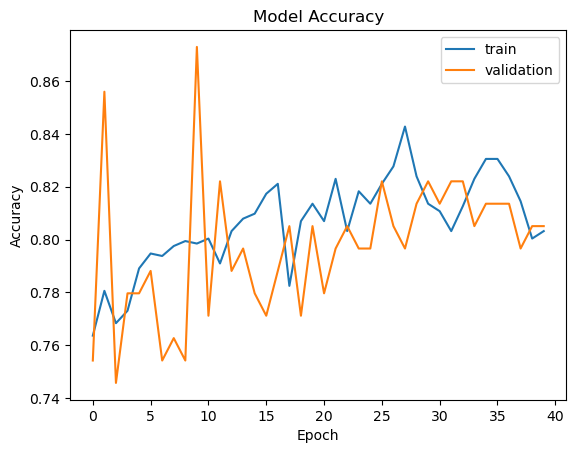

In [34]:
# Predict and evaluate the model
predictions = (model.predict(X_test) > 0.5).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

# Plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Train Loss: 0.3382, Train Accuracy: 0.8466
Test Loss: 0.3463, Test Accuracy: 0.8243
10/10 [==============================] - 0s 2ms/step
Precision: 0.8701
Recall: 0.8072
F1-Score: 0.8375


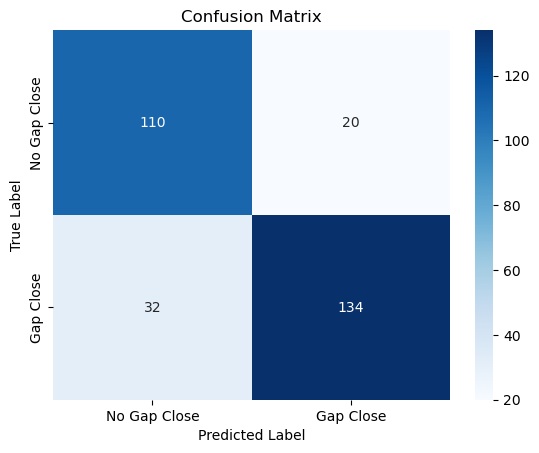

In [35]:
# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Make predictions
predictions = model.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)  # Convert probabilities to binary classes

# Calculate additional metrics
precision = precision_score(y_test, predicted_classes)
recall = recall_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Gap Close', 'Gap Close'], yticklabels=['No Gap Close', 'Gap Close'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

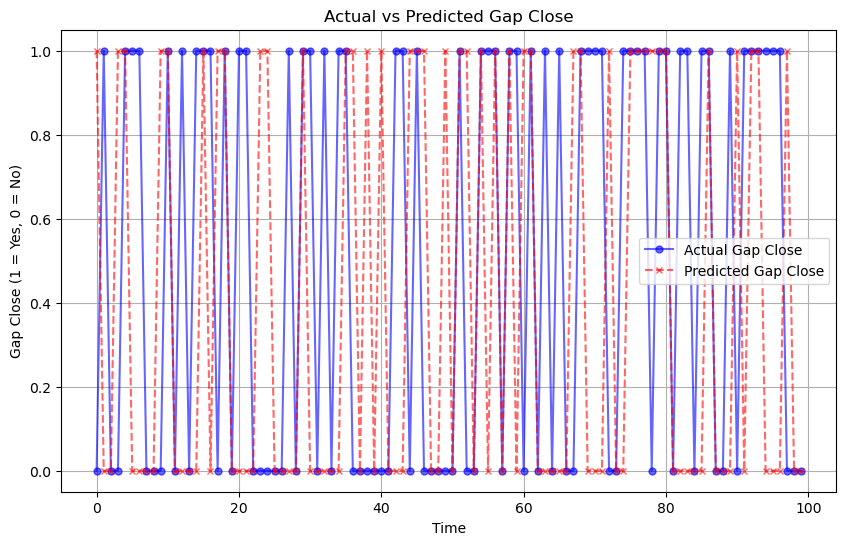

In [36]:
#Data setup 
time_steps = np.arange(100)  
actual_labels = np.random.randint(0, 2, size=100)  
predicted_labels = np.random.randint(0, 2, size=100)  

# Create the plot
plt.figure(figsize=(10, 6))  
plt.plot(time_steps, actual_labels, 'o', color='blue', linestyle='-', markersize=5, alpha=0.6, label='Actual Gap Close')  # Blue circles, semi-transparent
plt.plot(time_steps, predicted_labels, 'x', color='red', linestyle='--', markersize=5, alpha=0.6, label='Predicted Gap Close')  # Red crosses, semi-transparent

# Adding labels, title, and legend
plt.xlabel('Time')
plt.ylabel('Gap Close (1 = Yes, 0 = No)')
plt.title('Actual vs Predicted Gap Close')
plt.legend()
plt.grid(True)  
plt.show()